# Inference

Have a look into the predictions of a certain model on a specific orbit!

In [1]:
import constants as c
import harry_plotter
import models
import torch
import torch.nn.functional as F
import yaml

from tqdm.notebook import tqdm
from messenger_dataset import MessengerDataset
from utils import ioutils, torchutils

In [2]:
MODEL_RUN = 612
EPOCH = 20
ORBIT_ID = 42

Load model checkpoint and hyperparameters

In [3]:
run_path = ioutils.resolve_path(c.RUNS_DIR) / c.RUN_NAME(MODEL_RUN)
state_dict = torch.load(ioutils.resolve_path(run_path) / c.CKPT_SUBDIR / c.CKPT_FILE(EPOCH))
with open(run_path / c.HPARAMS_FILE) as f:
    HPARAMS = yaml.load(f, yaml.FullLoader)

Load the specified inference orbit

In [4]:
ds = MessengerDataset(ioutils.resolve_path(c.DATA_DIR),
                      features=HPARAMS["features"],
                      window_size=HPARAMS["window_size"],
                      future_size=HPARAMS["future_size"],
                      use_orbits=[ORBIT_ID])

Reconstruct the model

In [5]:
Arch = getattr(models, HPARAMS["model_arch"])
model = Arch(num_channels=len(HPARAMS["features"]),
             window_size=HPARAMS["window_size"],
             future_size=HPARAMS["future_size"],
             hidden_sizes=[HPARAMS[f"hidden_size{i}"] for i in range(HPARAMS["hidden_layers"])],
             channel_sizes=[HPARAMS[f"channel_size{i}"] for i in range(HPARAMS["conv_layers"])],
             kernel_sizes=[HPARAMS[f"kernel_size{i}"] for i in range(HPARAMS["conv_layers"])],
             stride_sizes=[HPARAMS[f"stride_size{i}"] for i in range(HPARAMS["conv_layers"])],
             pool_sizes=[HPARAMS[f"pool_size{i}"] for i in range(HPARAMS["conv_layers"])],
             rnn_layers=HPARAMS["rnn_layers"],
             rnn_state_size=HPARAMS["rnn_state_size"],
             dropout_rate=HPARAMS["dropout_rate"])
model.load_state_dict(state_dict)
model.eval()

print(f"trainable params: {torchutils.count_trainable_params(model)}")

trainable params: 267333


Put all window slices into one large batch

In [6]:
all_windows = torch.stack([sample for sample, label in tqdm(ds)])

  0%|          | 0/43313 [00:00<?, ?it/s]

Classify each time step in each of the windows

In [48]:
pred = model(all_windows)                   # predict class probabilities
pred = pred[:, :, :HPARAMS["window_size"]]  # discard future predictions
pred = pred.flip([2])                       # reverse the time dimension

In [57]:
pred_argmax = pred.argmax(dim=1)                   # select the class with highest probability

In [59]:
pred_avg = F.softmax(pred, dim=1)

In [60]:
labels_avg = torch.tensor([pred_avg.diagonal(dim1=0, dim2=2, offset=i).mean(dim=1).argmax()
                       for i in tqdm(range(pred.shape[2] - 1, -pred.shape[0], -1))])

  0%|          | 0/43432 [00:00<?, ?it/s]

Reduce predictions for each time step to a single one by majority voting

In [70]:
labels_argmax = torch.tensor([pred_argmax.diagonal(dim1=0, dim2=1, offset=i).mode().values
                       for i in tqdm(range(pred.shape[2] - 1, -pred.shape[0], -1))])

  0%|          | 0/43432 [00:00<?, ?it/s]

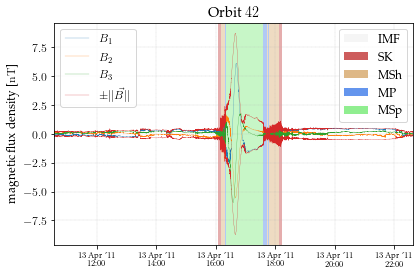

In [71]:
df_orbit = ds.get_orbits()[0]
figpath = str(ioutils.resolve_path(c.TEMP_DIR) / c.MESSENGER(ORBIT_ID)) + "_inference_argmax.pdf"
harry_plotter.plot_orbit(
    df_orbit.index,
    (df_orbit["BX_MSO"],
    df_orbit["BY_MSO"],
    df_orbit["BZ_MSO"]),
    symbol="B",
    labels=labels_argmax,
    title=f"Orbit ${ORBIT_ID}$",
    ylabel="magnetic flux density [\si{nT}]",
    outfile=figpath
)

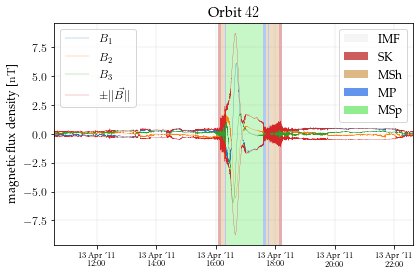

In [64]:
df_orbit = ds.get_orbits()[0]
figpath = str(ioutils.resolve_path(c.TEMP_DIR) / c.MESSENGER(ORBIT_ID)) + "_inference_avg.pdf"
harry_plotter.plot_orbit(
    df_orbit.index,
    (df_orbit["BX_MSO"],
    df_orbit["BY_MSO"],
    df_orbit["BZ_MSO"]),
    symbol="B",
    labels=labels_avg,
    title=f"Orbit ${ORBIT_ID}$",
    ylabel="magnetic flux density [\si{nT}]",
    outfile=figpath
)